In [2]:
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### First Create LinearRegression Class which consist of 
- **Methods:** `fit` , `predict` , `score`

- **Attributes:** `Number of iterations` , `MSE` , `Parameters(thetas)` , `Cost_history` , `Parameters_history`

- **Hyperparameters** epochs , learning_rate , optimizer , batch_size, gamma , gradient_tolerance , cost_tolerance ,beta , beta_2 , epsilon

- **Optimizers** Batch gradient descent , mini_batch , stochastic with momentum , Nag , Adagrad , RMS , Adam  

In [80]:
class LinearReg:
    def __init__(self ,epochs = 1000 ,learning_rate = .01 ,optimizer = 'gd',gamma=.99,
                 batch_size = None , gradient_tolerance=.001, cost_tolerance=.001,
                 beta = .9 , beta_2 = .99 , epsilon =10**-8
                ):       
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.gradient_tolerance = gradient_tolerance
        self.cost_tolerance = cost_tolerance
        self.gamma = gamma
        self.beta = beta
        self.beta_2 = beta_2 
        self.epsilon = epsilon  
        
        
    def fit(self , X , y ):
    #Concat X , y  to shuffle and split data into batches
        data = np.column_stack((X, y))
    #shuffle data
        np.random.seed(42)
        data = np.random.permutation(data)
        
    #if there is no batch size work as Batch gradient descent
        if self.batch_size is None:
            self.batch_size = len(data)
    
    # add ones to the data
        data = np.c_[np.ones(data.shape[0]) , data]

    #initialize parameters
        thetas = np.zeros((data.shape[1]-1  , 1))
        v = np.zeros((data.shape[1]-1 , 1))
        m = np.zeros((data.shape[1]-1 , 1))
    
    #Emtpy list to save J for plots 
        cost_history = []
        parameters_history = []
        loss = []
    # Create batches 
        number_of_batches = len(data) // self.batch_size
        mini_batches = []
        for i in range(number_of_batches):
            mini_batch = data[i * self.batch_size: (i + 1) * self.batch_size]
            mini_batches.append(mini_batch)
        if len(data) % self.batch_size != 0:
            mini_batch = data[number_of_batches * self.batch_size:]
            mini_batches.append(mini_batch)

    # Get number of batches to iterate on it
        n_batches = len(mini_batches)   
    # Loop on epochs 
        for i in range(self.epochs):
        # loop on each batch 
            for _ in range(n_batches):
                
            #Adding parameters to list for plots
                parameters_history.append(thetas)
                
            #Splitting data X,y
                cols = mini_batches[_].shape[1]
                X = mini_batches[_][: , :cols-1]
                y = mini_batches[_][: , cols-1 :]
            #Get length of each batch 
                batch_length = len(X)
                
            #calculate predictions
                y_hat = X@thetas
                
            #calculate errors 
                error_vector = y_hat - y
                cost = np.square(np.linalg.norm(error_vector)) / (2 *batch_length)
                cost_history.append(cost)
                gradient_vector = (X.T @ error_vector) / batch_length
            #Update thetas
                if(self.optimizer == 'gd'):
                    thetas = thetas - (self.learning_rate * gradient_vector)
                    
                elif (self.optimizer == 'momentum'):
                    v = (self.gamma * v) + (self.learning_rate * gradient_vector)        
                    thetas = thetas - v
                    
                elif(self.optimizer == 'nag'):
                    theta_temp = thetas - (self.gamma * v)
                    y_hat_temp = X@theta_temp
                    error_temp = y_hat_temp - y
                    gradient_vector = (X.T @ error_temp) / batch_length 
                    thetas = theta_temp - (self.learning_rate * gradient_vector)
                    v = (self.gamma * v) + (self.learning_rate * gradient_vector)
                    
                elif(self.optimizer == 'adagrad'):
                    v = v + gradient_vector**2
                    thetas = thetas - ((self.learning_rate / (np.sqrt(v) + self.epsilon)) * gradient_vector)
                    
                elif(self.optimizer == 'rms'):
                    v = (self.beta * v ) + ((1-self.beta)* gradient_vector**2)
                    thetas = thetas - ((self.learning_rate / (np.sqrt(v) + self.epsilon)) * gradient_vector)
                    
                elif(self.optimizer == 'adam'):
                    v = (self.beta_2 * v) + ((1-self.beta_2)* gradient_vector**2)
                    v_corr = v / (1-(self.beta_2**(i+1)))
                    m = (self.beta * m) + ((1-self.beta) * gradient_vector)
                    m_corr = m / (1- (self.beta**(i+1)))
                    thetas = thetas - (((self.learning_rate / (np.sqrt(v_corr) + self.epsilon)) * m_corr))         
        
        
        #Checking if the gradient approximately equal zero or not or if there is no update in cost 
        #Stop criteria
            gradient_norm = np.linalg.norm(gradient_vector)
            if (gradient_norm < self.gradient_tolerance):
                print("Gradient norm almost equal zero")
                break
            if (i > 2):
                if (np.abs(loss[-2] - loss[-1]) < self.cost_tolerance):
                        print("Update between Costs almost equal zero")
                        break
            loss.append(cost)
    #Putting outputs of the algorithm into attributes for usage 
        self.iterations = i
        self.cost = cost
        self.parameters = thetas
        self.cost_history = cost_history
        self.parameters_history = parameters_history
        
        
    def predict(self,X):
        X = np.c_[np.ones(X.shape[0]) , X]        
        prediction = X@self.parameters
        return prediction        
    def score(self, X , y):
        from sklearn.metrics import r2_score
        return r2_score(self.predict(X), y)

### Second Create BFGS optimizer algorithm  Class which consist of 
- **Methods:** `fit` , `predict` , `score`

- **Attributes:** `Number of iterations` , `MSE` , `Parameters(thetas)`

- **Hyperparameters** iterations , learning_rate, gradient_tolerance , cost_tolerance 


In [3]:
class bfgs:
    def __init__(self , iterations = 1000 , learning_rate = .01 , cost_tolerance = .001 , gradient_tolerance =.001):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.gradient_tolerance = gradient_tolerance
        self.cost_tolerance = cost_tolerance
            
            
    def fit(self , X , y):
        
        # Add ones to X 
        X = np.c_[np.ones(X.shape[0]), X] 
        
        # Reshape y in case it's shapeless
        y = np.array(y)
        y = y.reshape(-1, 1)
        
        # initialize thetas
        thetas_0 = np.zeros((X.shape[1],1))
        thetas_1 = np.full((X.shape[1],1) , .0001)
        
        # initialize B-inverse
        B_inv = np.eye(X.shape[1])
        
        # calculate gradient  for  thetas_1 for only 1 time
        m = len(X)
        y_hat_1 = X@thetas_1
        error_vector_1 = y_hat_1 - y
        cost_1 = np.square(np.linalg.norm(error_vector_1) / (2 *m))
        gradient_vector_1 = (X.T @ error_vector_1) / m

        #create list to store costs for cost check
        cost_history = []


        for i in range(self.iterations):

            #Calculate delta theta
            delta_theta = thetas_0 - thetas_1
            thetas_1 = thetas_0


            # calculate gradient  for both thetas---> 0 & 1
            y_hat_0 = X@thetas_0
            error_vector_0 = y_hat_0 - y
            cost_0 = np.square(np.linalg.norm(error_vector_0) / (2 *m))
            cost_history.append(cost_0)
            gradient_vector_0 = (X.T @ error_vector_0) / m


            #check if norm of the gradient is approximately zero or not or there is no difference in costs 'No update'
            gradient = np.linalg.norm(gradient_vector_0)
            if (gradient < self.gradient_tolerance):
                print("Gradient almost equal zero 'Converged'")
                break
            if(i > 2):
                if (np.abs(cost_history[-2] - cost_history[-1]) < self.cost_tolerance):
                    print("Update between Costs almost equal zero 'Converged'")
                    break

            #If not then calculate delta gradient 
            delta_gradient = gradient_vector_0 - gradient_vector_1
            gradient_vector_1 = gradient_vector_0

            #calculate new B_inv
            term1 = np.eye(X.shape[1]) - ((delta_theta @ delta_gradient.T) * np.linalg.inv(delta_gradient.T @ delta_theta))

            term2 = np.eye(X.shape[1]) - ((delta_gradient @ delta_theta.T) * np.linalg.inv( delta_gradient.T @ delta_theta))

            term3 = (delta_theta @ delta_theta.T) * np.linalg.inv(delta_gradient.T @ delta_theta)

            B_inv = (term1 @ B_inv @ term2 ) + term3


            #Update thetas 
            thetas_0 = thetas_0 - (self.learning_rate* (B_inv @ gradient_vector_0))
            
            
        self.iterations = i
        self.cost = cost_0
        self.parameters = thetas_0
        
        
    def predict(self , X):
        X = np.c_[np.ones(X.shape[0]), X] 
        return X@self.parameters 
    
    
    def score(self, X , y):
        from sklearn.metrics import r2_score
        return r2_score(self.predict(X), y)
        

### Creating function for plotting

In [82]:
def plotting(cost_history , parameters):
    theta_0 = []
    theta_1 = []
    theta_2 = []
    theta_3 = []
    theta_4 = []
    for m in range(len(parameters)):
        theta_0.append(parameters[m][0][0])
        theta_1.append(parameters[m][1][0])
        theta_2.append(parameters[m][2][0])
        theta_3.append(parameters[m][3][0])
        theta_4.append(parameters[m][4][0])
    plt.figure(figsize=(12,8))
    plt.subplot(2,3,1)
    plt.plot(cost_history, marker="o",markersize=3)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.subplot(2,3,2)
    plt.plot(theta_0 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_0")
    plt.subplot(2,3,3)
    plt.plot(theta_1 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_1")
    plt.ylabel("Cost")
    plt.subplot(2,3,4)
    plt.plot(theta_2 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_2")
    plt.ylabel("Cost")
    plt.subplot(2,3,5)
    plt.plot(theta_3 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_3")
    plt.ylabel("Cost")
    plt.subplot(2,3,6)
    plt.plot(theta_4 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_4")
    plt.ylabel("Cost")

## Reading Data 

In [4]:
df = pd.read_csv('Dummy Data Hss.csv')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4546 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4546 non-null   float64
 1   Radio         4546 non-null   float64
 2   Social Media  4546 non-null   float64
 3   Influencer    4546 non-null   object 
 4   Sales         4546 non-null   float64
dtypes: float64(4), object(1)
memory usage: 213.1+ KB


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Influencer'] = label_encoder.fit_transform(df['Influencer'])
df.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,1,54.732757
1,13.0,9.237765,2.409567,1,46.677897
2,41.0,15.886446,2.913410,1,150.177829
3,83.0,30.020028,6.922304,1,298.246340
4,15.0,8.437408,1.405998,2,56.594181


In [7]:
X = df.drop(columns=['Sales'])
y = df['Sales']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X  ,y ,test_size= .2 , random_state=42)

## First try LinearRegression from sklearn

In [87]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
print('train score = ',model.score(X_train,y_train))
y_pred = model.predict(X_test)
print('test score = ' ,r2_score(y_pred , y_test))

train score =  0.9989911802100335
test score =  0.9990105465349228


## Then Trying full batch  gradient descent with learning rate = .0001 and cost tolerance = .01 and 500 epochs

In [88]:
My_model = LinearReg(epochs=500, learning_rate=.0001 , cost_tolerance = .01)
My_model.fit(X_train,y_train)
print('r2_score  = ' , My_model.score(X_train,y_train), 'with number of iterations = ' , My_model.iterations)
print('r2_score for test  = ' , My_model.score(X_test,y_test))
print('Optimum parameters : \n ' ,My_model.parameters)
print('Cost value = ' , My_model.cost)

Update between Costs almost equal zero
r2_score  =  0.9984420281712059 with number of iterations =  425
r2_score for test  =  0.9984877816227113
Optimum parameters : 
  [[0.04258163]
 [3.40842047]
 [0.43003344]
 [0.07689095]
 [0.05812802]]
Cost value =  6.7453330788572785


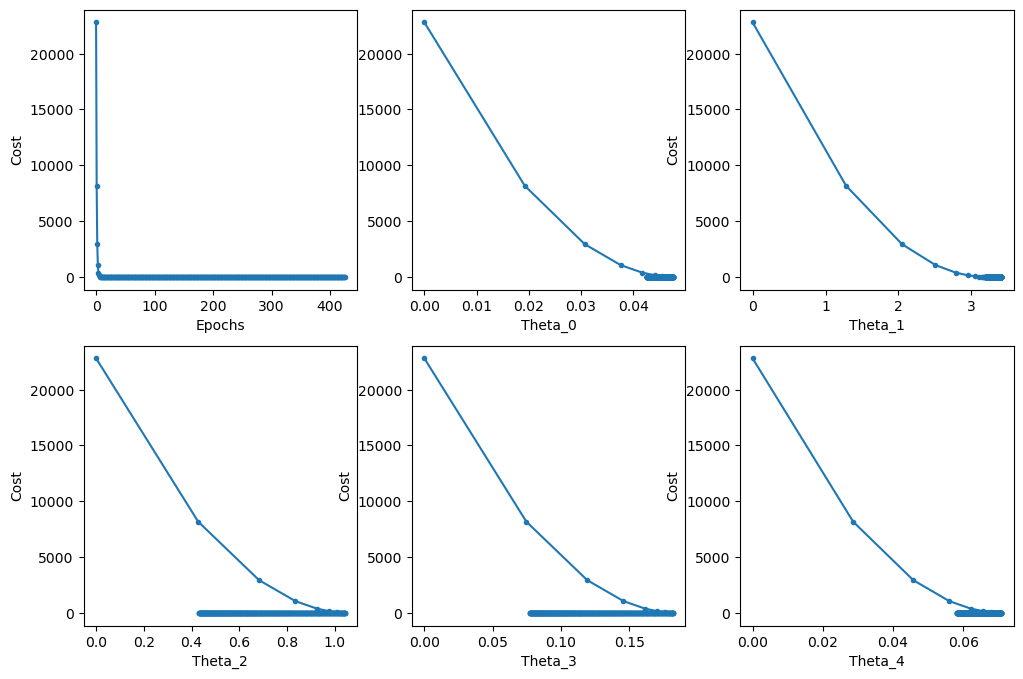

In [89]:
plotting(My_model.cost_history , My_model.parameters_history)

## Then Trying stochastic gradient descent with learning rate = .0001

In [90]:
my_model = LinearReg(epochs=50 , learning_rate=.0001 , batch_size=1 )
my_model.fit(X_train,y_train)
print('r2_score  = ' , my_model.score(X_train,y_train), 'with number of iterations = ' , my_model.iterations)
print('r2_score for test  = ' , my_model.score(X_test,y_test))
print('Optimum parameters : \n ' ,my_model.parameters)
print('Cost value = ' , my_model.cost)

Update between Costs almost equal zero
r2_score  =  0.9987479039702004 with number of iterations =  8
r2_score for test  =  0.9987722682600023
Optimum parameters : 
  [[ 0.00459107]
 [ 3.59075508]
 [-0.01176061]
 [-0.0276311 ]
 [-0.04054141]]
Cost value =  0.09421762144843712


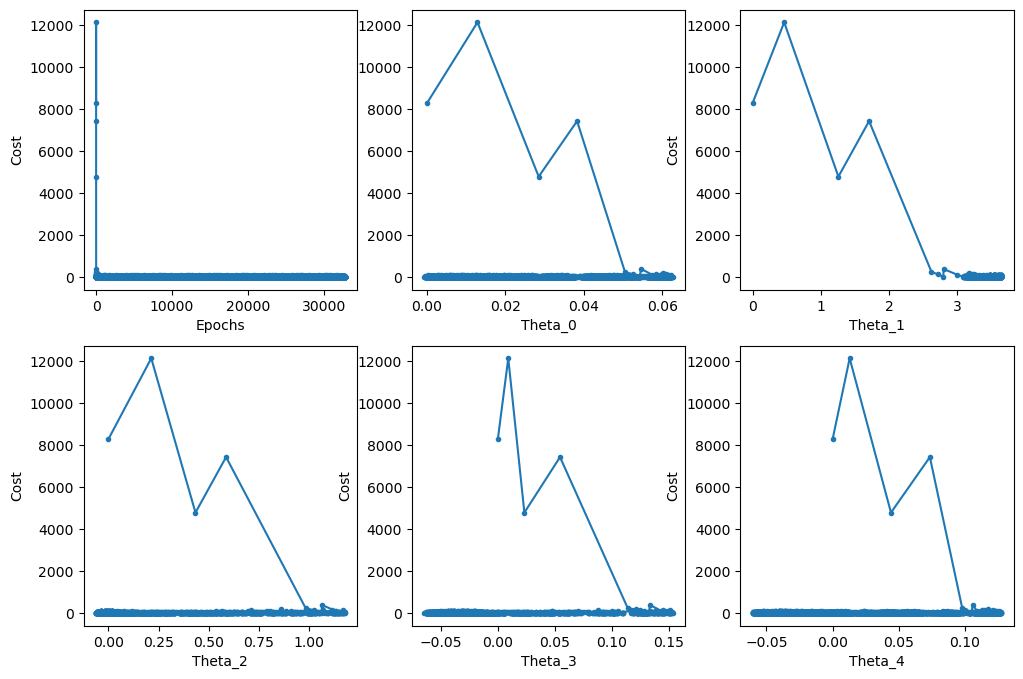

In [91]:
plotting(my_model.cost_history , my_model.parameters_history)

## Then Trying mini_batch with learning rate = .0001 and batch_size = 64

In [92]:
mb = LinearReg(epochs= 1000 , learning_rate =.0001 , batch_size=64 , cost_tolerance = .001)
mb.fit(X_train,y_train)
print('r2_score  = ' , mb.score(X_train,y_train), 'with number of iterations = ' , mb.iterations)
print('r2_score for test  = ' , mb.score(X_test,y_test))
print('Optimum parameters : \n ' ,mb.parameters)
print('Cost value = ' , mb.cost)

Update between Costs almost equal zero
r2_score  =  0.9989393414639776 with number of iterations =  17
r2_score for test  =  0.9989729751668731
Optimum parameters : 
  [[0.04035382]
 [3.51759822]
 [0.11724534]
 [0.02970715]
 [0.05166298]]
Cost value =  3.333654116566035


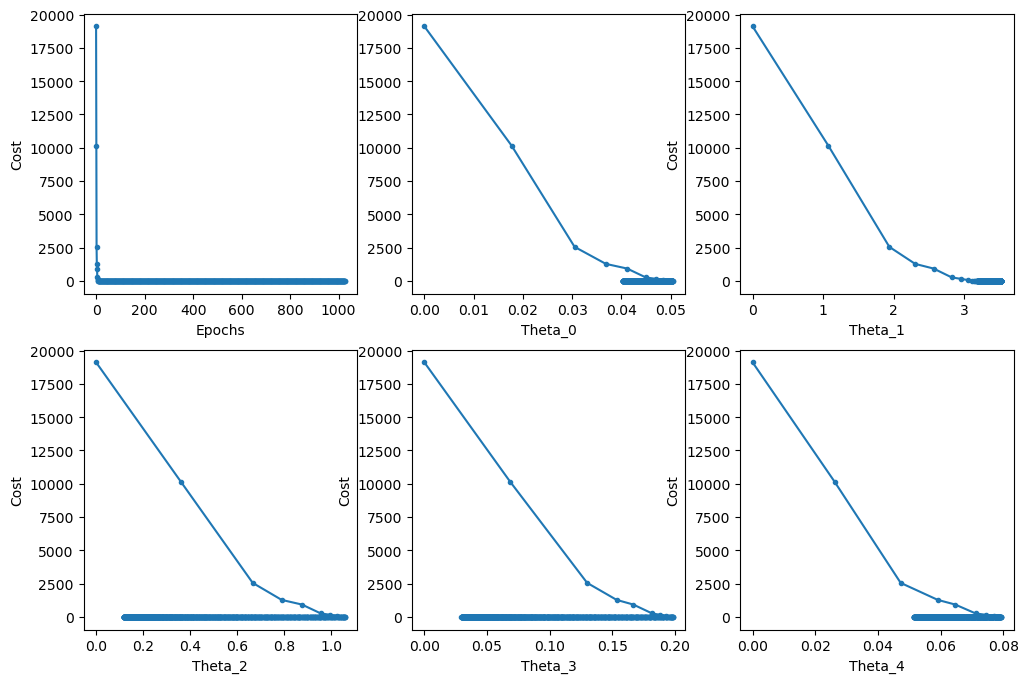

In [93]:
plotting(mb.cost_history , mb.parameters_history)

## Then Trying Momentum with learning rate = .0001 , gamma = .9

In [94]:
momentum = LinearReg(learning_rate=.0001 ,optimizer='momentum' , gamma=.9)
momentum.fit(X_train,y_train)
print('r2_score  = ' , momentum.score(X_train,y_train), 'with number of iterations = ' , momentum.iterations)
print('r2_score for test  = ' , momentum.score(X_test,y_test))
print('Optimum parameters : \n ' ,momentum.parameters)
print('Cost value = ' , momentum.cost)

Update between Costs almost equal zero
r2_score  =  0.9989832064335007 with number of iterations =  151
r2_score for test  =  0.9990074026254291
Optimum parameters : 
  [[ 3.54494912e-02]
 [ 3.55234855e+00]
 [ 1.33279006e-02]
 [-4.56824128e-04]
 [ 3.67372833e-02]]
Cost value =  4.410654171676477


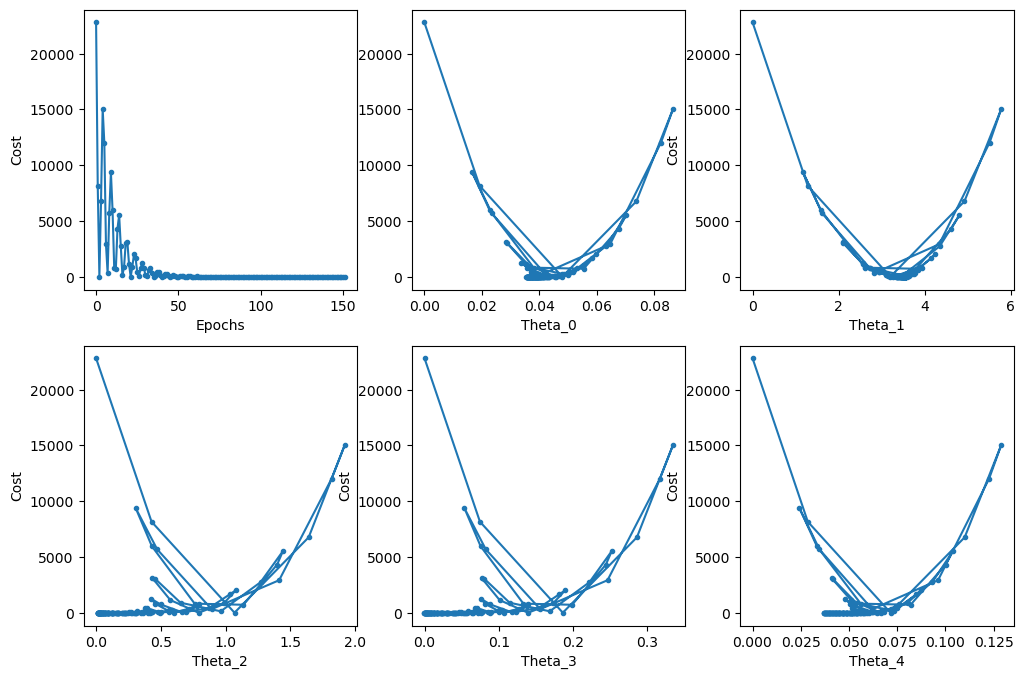

In [95]:
plotting(momentum.cost_history , momentum.parameters_history)

## Then Adam with learning rate = .5 , beta = .9 , beta_2 = .99

In [96]:
adam = LinearReg(learning_rate=.5 ,optimizer='adam' ,beta= .9 , beta_2=.99 , batch_size=512 )
adam.fit(X_train,y_train)
print('r2_score  = ' , adam.score(X_train,y_train), 'with nuadamer of iterations = ' , adam.iterations)
print('r2_score for test  = ' , adam.score(X_test,y_test))
print('Optimum parameters : \n ' ,adam.parameters)
print('Cost value = ' , adam.cost)

Update between Costs almost equal zero
r2_score  =  0.9989491176957968 with nuadamer of iterations =  37
r2_score for test  =  0.9989659634407405
Optimum parameters : 
  [[ 1.04459216]
 [ 3.5324898 ]
 [ 0.0729115 ]
 [-0.15153533]
 [-0.21913603]]
Cost value =  3.5762508045538044


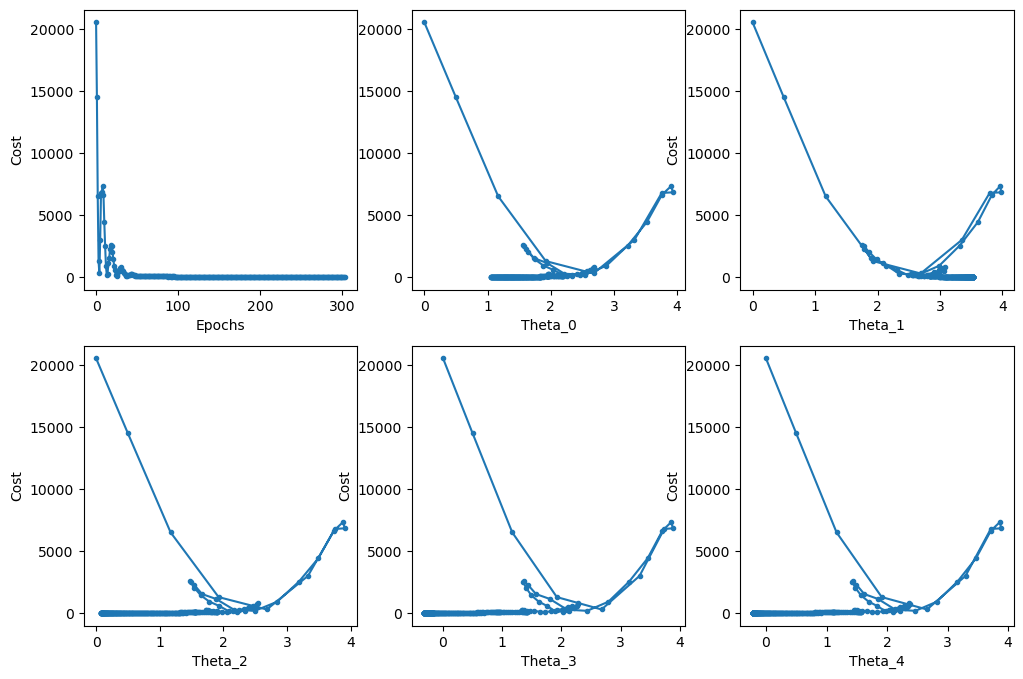

In [97]:
plotting(adam.cost_history , adam.parameters_history)

## Trying bfgs 

In [5]:
model = bfgs(learning_rate = .3)
model.fit(X_train,y_train)
print('r2_score  = ' , model.score(X_train,y_train), 'with numodeler of iterations = ' , model.iterations)
print('r2_score for test  = ' , model.score(X_test,y_test))
print('Optimum parameters : \n ' ,model.parameters)
print('Cost value = ' , model.cost)

NameError: name 'X_train' is not defined

## Another Data 'Stundent Performance'

In [99]:
def plotting(cost_history , parameters):
    theta_0 = []
    theta_1 = []
    theta_2 = []
    theta_3 = []
    theta_4 = []
    theta_5 = []
    theta_6 = []
    theta_7 = []

    for m in range(len(parameters)):
        theta_0.append(parameters[m][0][0])
        theta_1.append(parameters[m][1][0])
        theta_2.append(parameters[m][2][0])
        theta_3.append(parameters[m][3][0])
        theta_4.append(parameters[m][4][0])
        theta_5.append(parameters[m][4][0])
        theta_6.append(parameters[m][4][0])
        theta_7.append(parameters[m][4][0])

    plt.figure(figsize=(12,8))
    plt.subplot(3,3,1)
    plt.plot(cost_history, marker="o",markersize=3)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.subplot(3,3,2)
    plt.plot(theta_0 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_0")
    plt.subplot(3,3,3)
    plt.plot(theta_1 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_1")
    plt.ylabel("Cost")
    plt.subplot(3,3,4)
    plt.plot(theta_2 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_2")
    plt.ylabel("Cost")
    plt.subplot(3,3,5)
    plt.plot(theta_3 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_3")
    plt.ylabel("Cost")
    plt.subplot(3,3,6)
    plt.plot(theta_4 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_4")
    plt.ylabel("Cost")
    plt.subplot(3,3,7)
    plt.plot(theta_5 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_5")
    plt.ylabel("Cost")
    plt.subplot(3,3,8)
    plt.plot(theta_6 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_6")
    plt.ylabel("Cost")
    plt.subplot(3,3,9)
    plt.plot(theta_7 , cost_history, marker="o",markersize=3)
    plt.xlabel("Theta_7")
    plt.ylabel("Cost")

In [100]:
df = pd.read_csv('Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [102]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes' : 1 , 'No' : 0})

In [103]:
X = df.drop(columns = ['Performance Index'])

In [104]:
y = df['Performance Index']

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X  ,y ,test_size= .2 , random_state=42)

In [106]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
print('train score = ',model.score(X_train,y_train))
y_pred = model.predict(X_test)
print('test score = ' ,r2_score(y_pred , y_test))

train score =  0.9886898790682355
test score =  0.9887203279837657


In [107]:
grad = LinearReg(epochs = 3000, learning_rate=.0001)
grad.fit(X_train,y_train)
print('r2_score  = ' , grad.score(X_train,y_train), 'with number of iterations = ' , grad.iterations)
print('r2_score for test  = ' , grad.score(X_test,y_test))
print('Optimum parameters : \n ' ,grad.parameters)
print('Cost value = ' , grad.cost)

Update between Costs almost equal zero
r2_score  =  0.8343162380085074 with number of iterations =  2908
r2_score for test  =  0.8240835012836139
Optimum parameters : 
  [[-0.27692617]
 [ 1.82755568]
 [ 0.79333314]
 [-0.09110539]
 [-0.96401009]
 [-0.29584518]]
Cost value =  17.67060484577382


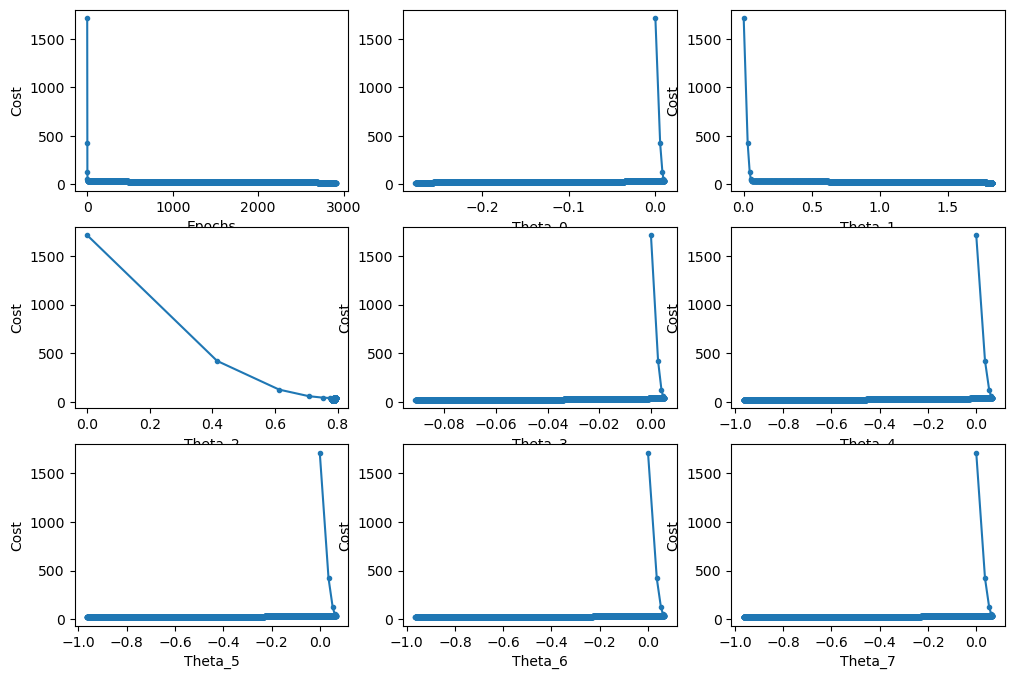

In [108]:
plotting(grad.cost_history , grad.parameters_history)

In [109]:
grad = LinearReg(epochs = 1000, learning_rate=.0001 , batch_size=1)
grad.fit(X_train,y_train)
print('r2_score  = ' , grad.score(X_train,y_train), 'with number of iterations = ' , grad.iterations)
print('r2_score for test  = ' , grad.score(X_test,y_test))
print('Optimum parameters : \n ' ,grad.parameters)
print('Cost value = ' , grad.cost)

Update between Costs almost equal zero
r2_score  =  0.9828769189640532 with number of iterations =  254
r2_score for test  =  0.9833663080444329
Optimum parameters : 
  [[-33.66690621]
 [  2.87097637]
 [  0.99246858]
 [  0.62917522]
 [  0.48436783]
 [  0.19513285]]
Cost value =  4.489694634576739


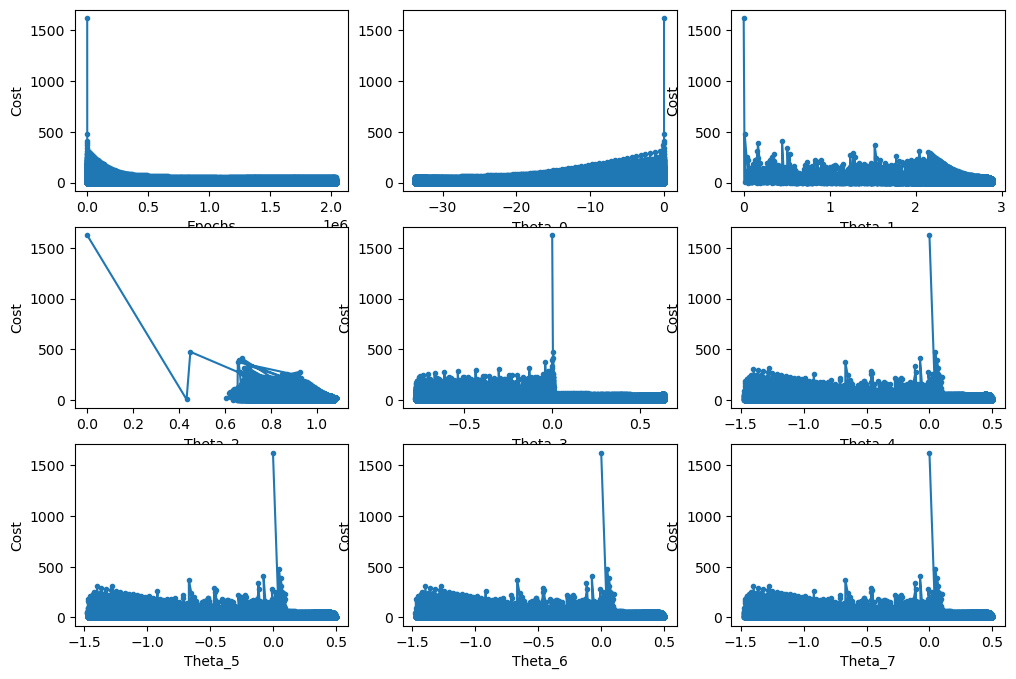

In [110]:
plotting(grad.cost_history , grad.parameters_history)

In [111]:
grad = LinearReg(epochs = 1000, learning_rate=.0001 , batch_size=216)
grad.fit(X_train,y_train)
print('r2_score  = ' , grad.score(X_train,y_train), 'with number of iterations = ' , grad.iterations)
print('r2_score for test  = ' , grad.score(X_test,y_test))
print('Optimum parameters : \n ' ,grad.parameters)
print('Cost value = ' , grad.cost)

Update between Costs almost equal zero
r2_score  =  0.8359934239152382 with number of iterations =  203
r2_score for test  =  0.8293066817009922
Optimum parameters : 
  [[-0.71361652]
 [ 2.16956439]
 [ 0.78656963]
 [-0.23595172]
 [-1.39202271]
 [-0.27270903]]
Cost value =  14.983215075373462


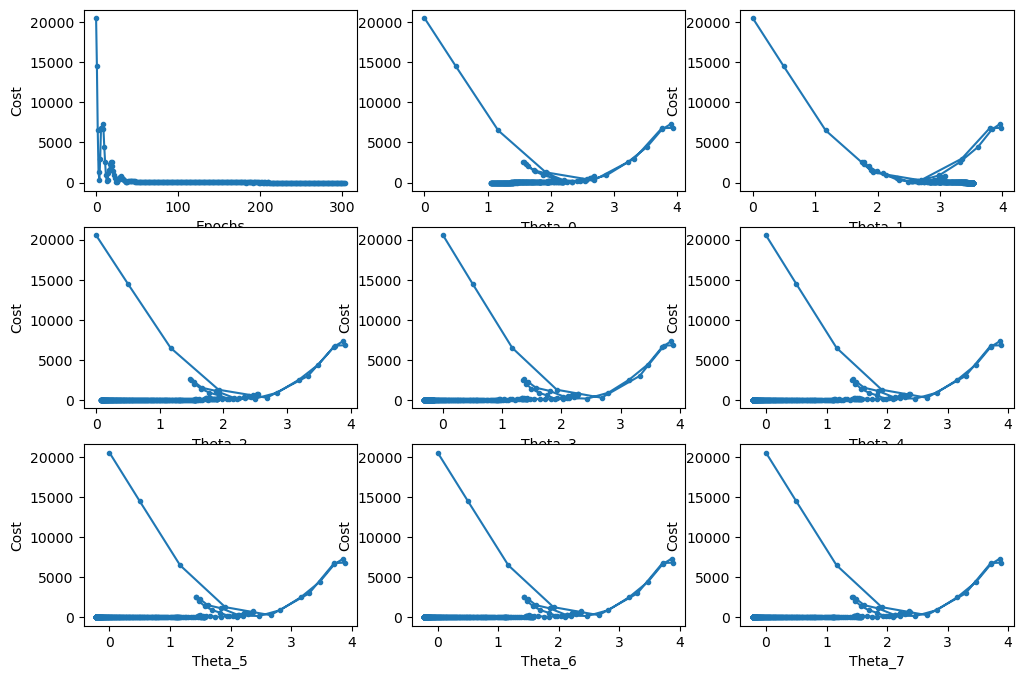

In [112]:
plotting(adam.cost_history , adam.parameters_history)

In [113]:
grad = LinearReg(epochs = 1000, learning_rate=.0001 ,optimizer='nag')
grad.fit(X_train,y_train)
print('r2_score  = ' , grad.score(X_train,y_train), 'with number of iterations = ' , grad.iterations)
print('r2_score for test  = ' , grad.score(X_test,y_test))
print('Optimum parameters : \n ' ,grad.parameters)
print('Cost value = ' , grad.cost)

Update between Costs almost equal zero
r2_score  =  0.840089396674772 with number of iterations =  78
r2_score for test  =  0.8260841636996104
Optimum parameters : 
  [[-0.23584937]
 [ 2.43088979]
 [ 0.77030239]
 [-0.07752807]
 [-1.0594679 ]
 [-0.45349019]]
Cost value =  17.622617368696883


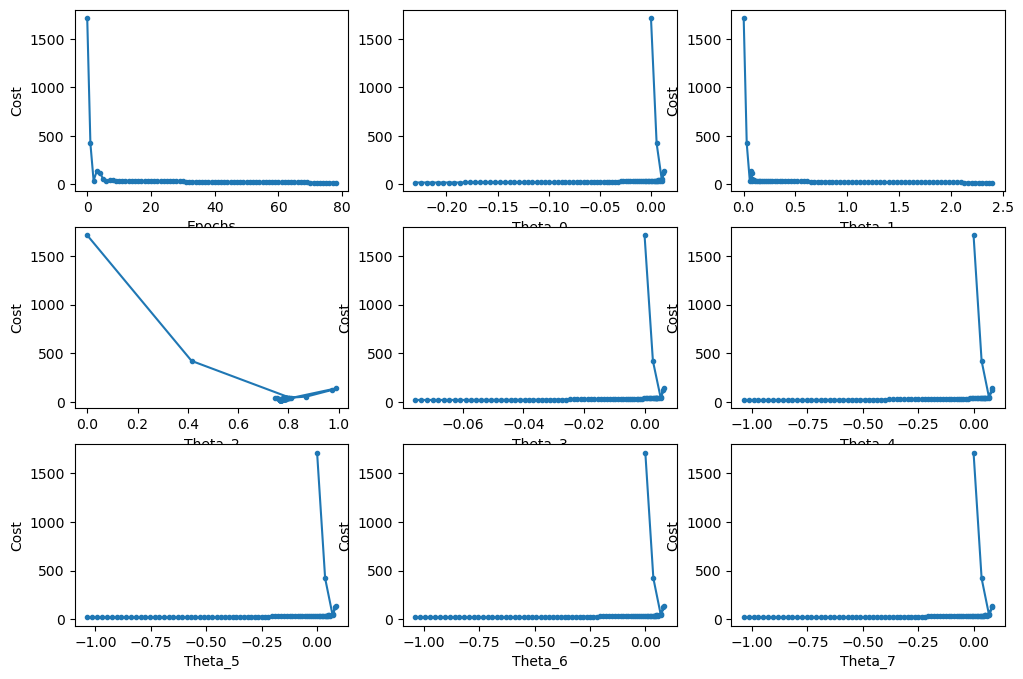

In [114]:
plotting(grad.cost_history , grad.parameters_history)

In [115]:
grad = LinearReg(epochs = 1000, learning_rate=.0001 ,optimizer='nag' , batch_size=216)
grad.fit(X_train,y_train)
print('r2_score  = ' , grad.score(X_train,y_train), 'with number of iterations = ' , grad.iterations)
print('r2_score for test  = ' , grad.score(X_test,y_test))
print('Optimum parameters : \n ' ,grad.parameters)
print('Cost value = ' , grad.cost)

Update between Costs almost equal zero
r2_score  =  0.9874215832288942 with number of iterations =  303
r2_score for test  =  0.9875370455548194
Optimum parameters : 
  [[-32.21312165]
 [  2.81169795]
 [  1.00149165]
 [  0.50590054]
 [  0.37745647]
 [  0.16632772]]
Cost value =  2.1932894522551587


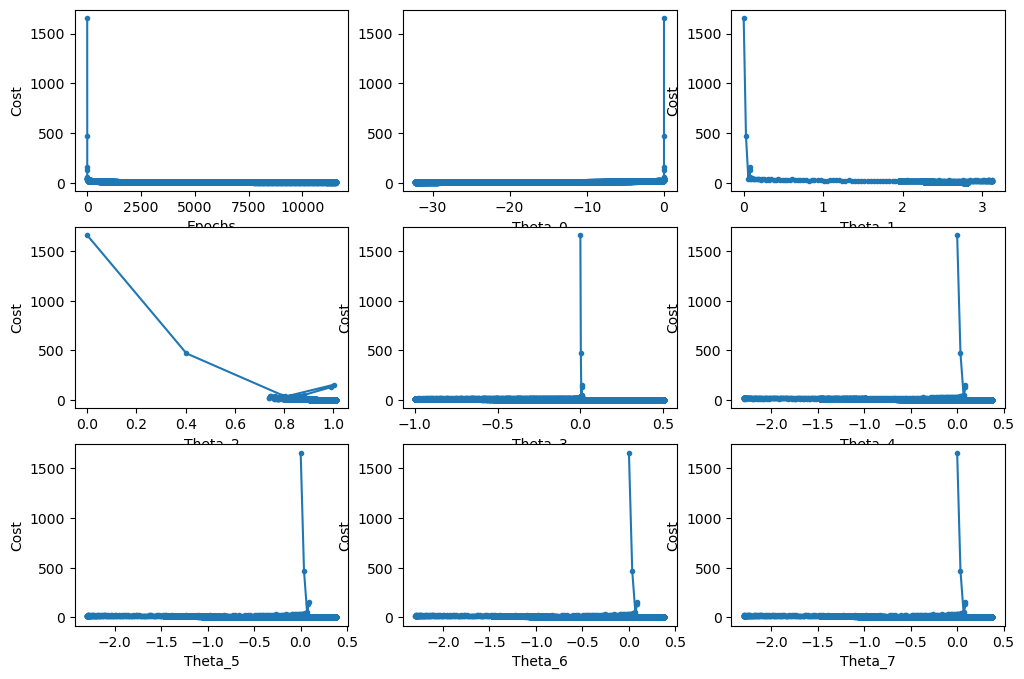

In [116]:
plotting(grad.cost_history , grad.parameters_history)

In [117]:
grad = LinearReg(epochs = 1000, learning_rate=.0001 ,optimizer='nag' , batch_size=1)
grad.fit(X_train,y_train)
print('r2_score  = ' , grad.score(X_train,y_train), 'with number of iterations = ' , grad.iterations)
print('r2_score for test  = ' , grad.score(X_test,y_test))
print('Optimum parameters : \n ' ,grad.parameters)
print('Cost value = ' , grad.cost)

Update between Costs almost equal zero
r2_score  =  0.9781096329424499 with number of iterations =  6
r2_score for test  =  0.9775273867834551
Optimum parameters : 
  [[-33.90902791]
 [  3.4831795 ]
 [  0.97022351]
 [  0.48220855]
 [  0.35861099]
 [  0.40622364]]
Cost value =  16.31600314397667


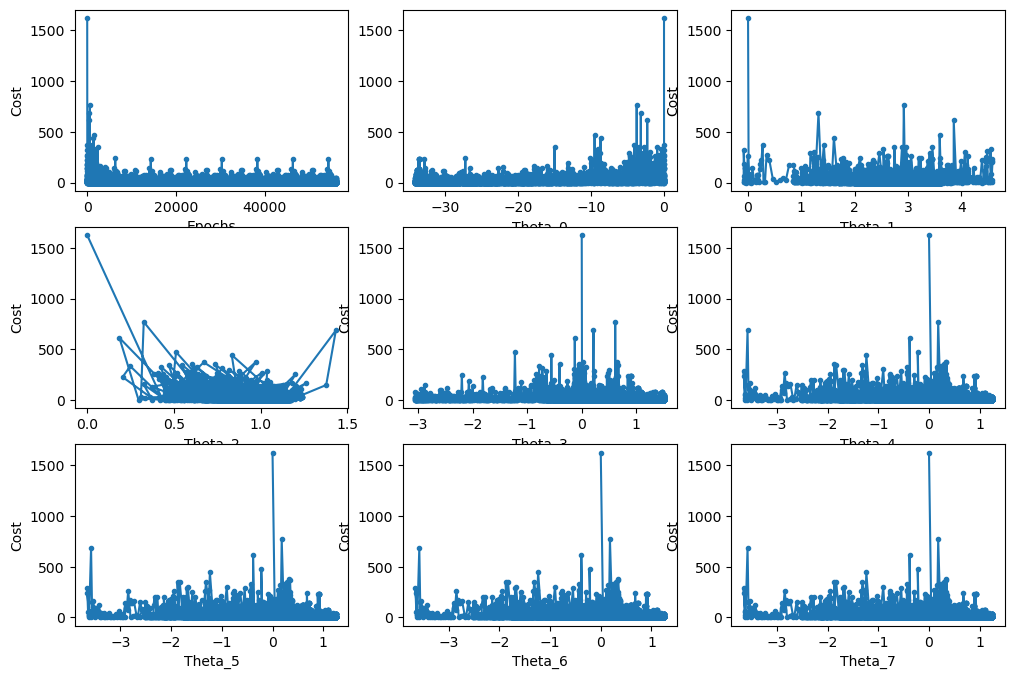

In [118]:
plotting(grad.cost_history , grad.parameters_history)

In [11]:
model = bfgs(learning_rate = 1)
model.fit(X_train,y_train)
print('r2_score  = ' , model.score(X_train,y_train), 'with numodeler of iterations = ' , model.iterations)
print('r2_score for test  = ' , model.score(X_test,y_test))
print('Optimum parameters : \n ' ,model.parameters)
print('Cost value = ' , model.cost)

Update between Costs almost equal zero 'Converged'
r2_score  =  0.9989421556534397 with numodeler of iterations =  9
r2_score for test  =  0.9989721005093267
Optimum parameters : 
  [[ 0.01990523]
 [ 3.56223374]
 [-0.02211764]
 [ 0.23582885]
 [-0.45134052]]
Cost value =  0.0006343959842360894


### Student_performance Dataset

In [17]:
df = pd.read_csv('Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [18]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes' : 1 , 'No' : 0 })
df = df.dropna()

In [19]:
X = df.drop(columns=['Performance Index'])
y = df['Performance Index']

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)
model.score(X,y)

0.9887523323780958

In [21]:
model = bfgs(learning_rate=1 , iterations = 1000 , cost_tolerance= .00001)
model.fit(X,y)
model.score(X,y)

Update between Costs almost equal zero 'Converged'


0.9883830823788929